In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

seed = 42
np.random.seed(seed=seed)

def train_generator(X_train, y_train, batch_size, target_names, setting='stft'):
    from tensorflow.keras import utils
    while True:
        for start in range(0, len(X_train), batch_size):
            x_batch = []
            y_batch = []            
            end = min(start + batch_size, len(X_train))
            train_batch = X_train[start:end]
            labels_batch = y_train[start:end]
            for i in range(len(train_batch)):
                data, _ = librosa.load(train_batch[i], sr = SR)
#                 data = random_data_shift(data, u = .2)
                # Expand dimensions
                data = np.expand_dims(data, axis = -1)
                if using_conv2d:
                    data = np.expand_dims(data, axis = -1)
                x_batch.append(data)
                y_batch.append(labels_batch[i])
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch

def valid_generator(X_val, y_val, batch_size, target_names, setting='stft'):
    from tensorflow.keras import utils
    while True:
        for start in range(0, len(X_val), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(X_val))
            test_batch = X_val[start:end]
            labels_batch = y_val[start:end]
            for i in range(len(test_batch)):
                data, _ = librosa.load(test_batch[i], sr = SR)
                # Expand dimensions
                data = np.expand_dims(data, axis = -1)
                if using_conv2d:
                    data = np.expand_dims(data, axis = -1)
                x_batch.append(data)
                y_batch.append(labels_batch[i])
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch
            
splitting = 'custom'
data_setting = 'raw'
model_setting = 'conv1d'

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


### Splitting mosquito data same way it was split to train

In [2]:
d = Dataset('Wingbeats')
d.read(loadmat=False)

X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting=splitting, dataset=d, downsampling=False, return_label_encoder=True)

X_train, X_val, y_train, y_val = X_train[0], X_val[0], y_train[0], y_val[0]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

get_labelencoder_mapping(le)

Species: all.
Read 279566 filenames in 5.33 seconds.
Species: Ae. aegypti.
Read 85553 filenames in 1.41 seconds.
['20170212', '20170211', '20170209', '20170208', '20170210', '20170207', '20170213', '20161213', '20170206', '20161212']
82989 train filenames, 2564 test filenames
Species: Ae. albopictus.
Read 20231 filenames in 1.37 seconds.
['20170301', '20170228', '20170227', '20170103', '20170102']
17440 train filenames, 2791 test filenames
Species: An. arabiensis.
Read 19297 filenames in 1.34 seconds.
['20170131', '20170317', '20170318', '20170320', '20170205', '20170203', '20170204', '20170202', '20170319', '20170313', '20170201', '20170314', '20170316', '20170130', '20170206', '20170315']
12897 train filenames, 2831 test filenames
Species: An. gambiae.
Read 49471 filenames in 1.34 seconds.
['20170121', '20170120', '20170123', '20170118', '20170117', '20170119', '20170116', '20170122', '20170109', '20170110']
45471 train filenames, 4000 test filenames
Species: C. quinquefasciatus.
Rea

{'Ae. aegypti': 0,
 'Ae. albopictus': 1,
 'An. arabiensis': 2,
 'An. gambiae': 3,
 'C. pipiens': 4,
 'C. quinquefasciatus': 5}

### Loading MosquitoNet and removing its last 2 layers

In [3]:
# Defining model parameters
merged = False
if merged:
    # Merging the mosquito genuses together
    y_train = pd.Series(y_train).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_val = pd.Series(y_val).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_test = pd.Series(y_test).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_MERGED_weights'
    print(pd.Series(y_train).value_counts())
else:
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_weights'
using_conv2d = False
traincf = TrainConfiguration(dataset=d, setting=data_setting, model_name=modelname)
model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# NOT LOADING MODELS
model.load_weights(TEMP_DATADIR+modelname+'.h5')
model.summary()

# cut_mosquito_model is the model without its last dropout and softmax
cut_mosquito_model = Model(model.inputs, model.layers[-3].output)

############ INPUT SHAPE:(5000, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4998, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4996, 16)          784       
_________________________________________________________________
batch_normalization (BatchNo (None, 4996, 16)          64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4994, 32)          1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4992, 32)          3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4992, 32)          128       
_________________________________________________________________
max_pooling1d (MaxPoo

## Reading Flies data and splitting into Train/Val/Test

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
import seaborn as sb
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
import deepdish as dd
from wavhandler import *

In [5]:
dconf = Dataset('Pcfruit_sensor49')
dconf.read(loadmat=False);
dconf.get_sensor_features(temp_humd=False)
sub = dconf.df_features

mel_test_dates = ['20191216','20191217','20191220','20191221','20191222','20191223',
                 '20191224','20191225','20191226','20191227','20191228','20191229',
                 '20191230','20191231','20200101','20200102','20200103','20200104',
                 '20200105','20200106','20200107','20200108','20200109','20200110',
                 '20200111','20200112','20200113','20200114','20200115','20200116',
                 '20200117','20200118','20200119']
mel_val_dates = [['20200131','20200201'],['20200307'],['20200313','20200314','20200315','20200316']]
suz_test_dates = ['20200207', '20200208']
suz_val_dates = [['20200209'],['20200214'],['20200219']]

Species: all.
Read 10264 filenames in 0.40 seconds.


,filenames,wavnames,date,datestr,date_day,date_hour,gain,y
0,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,F200211_220602_243_G_050_T_28.7_H_60.4,2020-02-11 22:06:02,20200211,11,22,050,D. suzukii
1,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,F200218_142815_044_G_050_T_29.3_H_53.6,2020-02-18 14:28:15,20200218,18,14,050,D. suzukii
2,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,F200219_021355_158_G_050_T_29.3_H_55.0,2020-02-19 02:13:55,20200219,19,2,050,D. suzukii
3,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,F200218_214233_140_G_050_T_29.3_H_44.8,2020-02-18 21:42:33,20200218,18,21,050,D. suzukii
4,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,F200210_021538_074_G_050_T_29.3_H_57.5,2020-02-10 02:15:38,20200210,10,2,050,D. suzukii


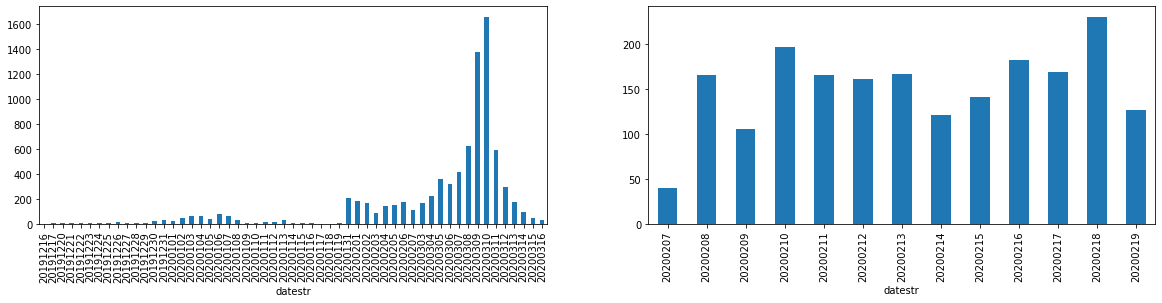

In [6]:
sub['y'] = dconf.df_features.filenames.apply(lambda x: x.split('/')[dconf.class_path_idx])
df_suz = sub[sub['y'] == 'D. suzukii']
df_mel = sub[sub['y'] == 'D. melanogaster']

plt.figure(figsize=(20,4))
plt.subplot(121); df_mel.groupby('datestr')['filenames'].count().plot(kind="bar")
plt.subplot(122); df_suz.groupby('datestr')['filenames'].count().plot(kind="bar")

df_suz.head()

In [7]:
mel_test = df_mel[df_mel.datestr.isin(mel_test_dates)][['filenames','y']]
suz_test = df_suz[df_suz.datestr.isin(suz_test_dates)][['filenames','y']]
suz_test.sample(5)

,filenames,y
121,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. suzukii
82,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. suzukii
993,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. suzukii
1279,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. suzukii
736,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. suzukii


In [8]:
# For the test set we made 1 dataframe for each insect species,
# but for the validation set we have a list of 3 dataframes for each species
# since we select three validation sets.
mel_val, suz_val = [],[]
for i in range(3):
    suz_val.append(df_suz[df_suz.datestr.isin(suz_val_dates[i])][['filenames','y']])
    mel_val.append(df_mel[df_mel.datestr.isin(mel_val_dates[i])][['filenames','y']])
mel_val[0].sample(5)

,filenames,y
3166,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
3131,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
2107,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
2226,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
2436,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster


In [9]:
lenc = LabelEncoder()
lenc.fit(dconf.y)

test = pd.concat([mel_test, suz_test])
Xf_test = test.filenames.tolist()
yf_test = lenc.transform(test.y).tolist()
# Trainval contains all data for training and validation sets [it excludes test set]
trainval = sub[~sub.filenames.isin(Xf_test)][['filenames','y']]
trainval.sample(5)

,filenames,y
2893,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
5378,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
8010,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
9470,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster
4002,/home/kalfasyan/data/insects/Pcfruit_sensor49/...,D. melanogaster


# Function to create model, extract features and train

In [10]:
def create_top_model(cut_mosquito_model):
    ### Creating a shallow model to put on top of Mosquito model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=cut_mosquito_model.output_shape[1:]))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    top_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return top_model

def extract_features_mosquitonet(Xf_train, yf_train, Xf_val, yf_val):
    ### Passing fly data through the cut Mosquito model to get output
    ##### This output will be used to train the shallow model for few epochs

    Xf_xtracted_train = cut_mosquito_model.predict_generator(valid_generator(Xf_train, 
                                                    yf_train, 
                                                    batch_size=128, 
                                                    setting='raw', 
                                                    target_names=['suz','mel']),
                                                steps = int(math.ceil(float(len(Xf_train)) / float(128))))

    Xf_xtracted_val = cut_mosquito_model.predict_generator(valid_generator(Xf_val, 
                                                    yf_val, 
                                                    batch_size=128, 
                                                    setting='raw', 
                                                    target_names=['suz','mel']),
                                                steps = int(math.ceil(float(len(Xf_val)) / float(128))))    
    return Xf_xtracted_train, Xf_xtracted_val

def train_model(Xf_train, yf_train, Xf_val, yf_val, Xf_xtracted_train, Xf_xtracted_val, 
                cut_mosquito_model, top_model, frozen_layers=0):
    
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(yf_train), y=yf_train)
    
    ### Training Shallow model for a few epochs
    traincf_flies = TrainConfiguration(dataset=dconf, setting='raw', monitor='val_accuracy', 
                                       model_name=f'top_model_flies', batch_size=32, epochs=5)
    top_model.fit(Xf_xtracted_train, yf_train, 
                  validation_data=(Xf_xtracted_val,yf_val),
                  batch_size=traincf_flies.batch_size, 
                  epochs=traincf_flies.epochs, 
                  callbacks=traincf_flies.callbacks_list,
                 class_weight=class_weights,
                 verbose=0);
    ### Freezing first few layers of MosquitoNet
    if frozen_layers > 0:
        for lay in cut_mosquito_model.layers[:frozen_layers]:
            lay.trainable = False
    ### Adding shallow model on top of the cut Mosquito model
    inputA = Input(cut_mosquito_model.input_shape[1:])
    outputA = cut_mosquito_model(inputA)
    outputB = top_model(outputA)
    modelC = Model(inputA, outputB)
    modelC.compile(loss='mse',
                  optimizer='adam',#optimizers.SGD(lr=1e-3, momentum=0.9),
                  metrics=['accuracy'])
    ### Training MosquitoNet+Shallow
    traincf_flies = TrainConfiguration(dataset=dconf, setting='raw', monitor='val_accuracy', es_patience=4, rlr_patience=4, model_name=f'whole_model_flies', batch_size=32)
    h = modelC.fit_generator(train_generator(Xf_train, yf_train, 
                                        batch_size=traincf_flies.batch_size,
                                        target_names=traincf_flies.target_names,
                                        setting=traincf_flies.setting),
                        steps_per_epoch = int(math.ceil(float(len(Xf_train)) / float(traincf_flies.batch_size))),
                        epochs = traincf_flies.epochs,
                        validation_data = valid_generator(Xf_val, yf_val,
                                                            batch_size=traincf_flies.batch_size,
                                                            target_names=traincf_flies.target_names,
                                                            setting=traincf_flies.setting),
                        validation_steps=int(math.ceil(float(len(Xf_test))/float(traincf_flies.batch_size))),
                        callbacks=traincf_flies.callbacks_list, 
                        class_weight=class_weights, 
                        verbose=0);

    yf_pred = modelC.predict_generator(valid_generator(Xf_test, 
                                                    yf_test, 
                                                    batch_size=128, 
                                                    setting='raw', 
                                                    target_names=['suz','mel']),
                                                steps = int(math.ceil(float(len(Xf_test)) / float(128))))
    return yf_pred, h, modelC


In [11]:
def myjob(trainval, mel_val, suz_val, Xf_test, yf_test, trial=0, frozen_layers=0, smpl=100, valset=0):
    savepath = f'../temp_data/merged{merged}_nr{frozen_layers}_samples{smpl}_val{valset}_trial{trial}.csv'
    print(savepath)
    if os.path.isfile(savepath):
        print("ALREADY EXISTS")
        return

    print(f'\n\n###########\nNOW USING {smpl} SAMPLES in {valset} VALIDATION FOLD\n##############')
    smpl_results = {}

    valfold_mel = trainval[trainval.filenames.isin(mel_val[valset].filenames)]
    valfold_suz = trainval[trainval.filenames.isin(suz_val[valset].filenames)]
    validation = pd.concat([valfold_mel, valfold_suz])
    Xf_val = validation.filenames.tolist()
    yf_val = lenc.transform(validation.y)

    train = trainval[~trainval.filenames.isin(validation.filenames)]
    train_smpl = shuffle(train.sample(smpl, random_state=seed), random_state=seed)
    Xf_train, yf_train = train_smpl.filenames.tolist(), lenc.transform(train_smpl.y)

    print(f"Train: \n{pd.Series(yf_train).value_counts()}")
    print(f"Val: \n{pd.Series(yf_val).value_counts()}")
    print(f"Test: \n{pd.Series(yf_test).value_counts()}")    

    # cut_mosquito_model = Model(model.inputs, model.layers[-3].output)
    top_model = create_top_model(cut_mosquito_model)
    Xf_xtracted_train, Xf_xtracted_val = extract_features_mosquitonet(Xf_train, yf_train, Xf_val, yf_val)
    yf_pred, h, modelC = train_model(Xf_train, yf_train, Xf_val, yf_val, Xf_xtracted_train, Xf_xtracted_val, 
                                     cut_mosquito_model, top_model, frozen_layers=frozen_layers)

    lb = LabelBinarizer()
    thr = 0.5
    yf_pred_thresholded = lb.fit_transform(yf_pred > thr)
    cm = confusion_matrix(yf_test, yf_pred_thresholded).astype(float)
    smpl_results['yf_test'] = yf_test
    smpl_results['yf_pred'] = yf_pred
    smpl_results['yf_pred_thresholded'] = yf_pred_thresholded
    smpl_results['nr_samples'] = smpl
    smpl_results['trial'] = trial
    smpl_results['frozen_layers'] = frozen_layers
    smpl_results['accuracy_score'] = accuracy_score(yf_test, yf_pred_thresholded)
    smpl_results['balanced_accuracy_score'] = balanced_accuracy_score(yf_test, yf_pred_thresholded)
    smpl_results['cm'] = cm
    #     smpl_results['classification_report'] = classification_report(yf_test, yf_pred_thresholded)
    smpl_results['history'] = h.history

    dd.io.save(savepath, smpl_results)
    print('Done.')

In [12]:
samples = [100, 175, 250, 325, 400, 500, 1000, 2000, 4000, 6000, 8000]
froz_layerlist = [0, 5, 15, 19]
trials = [0,1,2,3,4,5,6,7,8,9]

for trial in trials:
    for frozen_layers in froz_layerlist:
        for valset in range(3):
            for smpl in samples:
                myjob(trainval, mel_val, suz_val, Xf_test, yf_test, trial=trial, frozen_layers=frozen_layers, smpl=smpl, valset=valset)

../temp_data/mergedFalse_nr0_samples100_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples175_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples250_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples325_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples400_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples500_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples1000_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples2000_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples4000_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples6000_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples8000_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples100_val1_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples175_val1_trial0.csv
ALREADY EXISTS
../temp_data/mergedFalse_nr0_samples250_val1_trial0.csv
ALREADY EXISTS
.

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples100_val1_trial6.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.16479, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.16479 to 0.20974, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.20974 to 0.30337, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.30337 to 0.67978, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.67978 to 0.94007, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples175_val1_trial6.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.67978, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.67978 to 0.76779, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.76779

Epoch 00004: val_accuracy did not improve from 0.76779

Epoch 00005: val_accuracy improved from 0.76779 to 0.76966, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.86343, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples250_val1_trial6.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.69850, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.69850 to 0.77903, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.77903 to 0.78464, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.78464 to 0.78839, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.78839 to 0.79401, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flie

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples325_val1_trial6.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.77341, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.77341

Epoch 00003: val_accuracy did not improve from 0.77341

Epoch 00004: val_accuracy did not improve from 0.77341

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.77341
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.86343, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.86343

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples400_val1_trial6.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.78464, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.78464

Epoch 00003: val_accuracy improved from 0.78464 to 0.78839, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.78839 to 0.79026, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.79026 to 0.80524, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples500_val1_trial6.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.77341, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.77341

Epoch 00003: val_accuracy did not improve from 0.77341

Epoch 00004: val_accuracy did not improve from 0.77341

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.77341
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88600, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.88600

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples1000_val1_trial6.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.78652, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.78652 to 0.79026, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.79026 to 0.79963, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.79963 to 0.80337, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.80337 to 0.81648, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_fl

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples2000_val1_trial6.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89139, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89139 to 0.90449, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90449 to 0.90637, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.90637 to 0.91386, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.91386
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved f

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples4000_val1_trial6.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.80712, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.80712 to 0.83521, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.83521 to 0.83708, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.83708 to 0.84457, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.84457
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved f

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples6000_val1_trial6.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.87640, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.87640 to 0.89888, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.89888 to 0.91948, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.91948 to 0.92322, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.92322 to 0.92697, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples8000_val1_trial6.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.82772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.82772 to 0.85393, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.85393 to 0.85955, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.85955 to 0.86517, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.86517
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved f

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples100_val2_trial6.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.26240, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.26240 to 0.75620, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.75620

Epoch 00004: val_accuracy did not improve from 0.75620

Epoch 00005: val_accuracy did not improve from 0.75620

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.82258, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

E

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples175_val2_trial6.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.73760

Epoch 00003: val_accuracy did not improve from 0.73760

Epoch 00004: val_accuracy did not improve from 0.73760

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.73760
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.82258, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.82258

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples250_val2_trial6.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.73760

Epoch 00003: val_accuracy did not improve from 0.73760

Epoch 00004: val_accuracy did not improve from 0.73760

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.73760
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.82258, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.82258

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples325_val2_trial6.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.73760

Epoch 00003: val_accuracy did not improve from 0.73760

Epoch 00004: val_accuracy did not improve from 0.73760

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.73760
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.82258, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.82258

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples400_val2_trial6.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.73760

Epoch 00003: val_accuracy did not improve from 0.73760

Epoch 00004: val_accuracy did not improve from 0.73760

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.73760
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.82258, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.82258

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples500_val2_trial6.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.73760

Epoch 00003: val_accuracy did not improve from 0.73760

Epoch 00004: val_accuracy did not improve from 0.73760

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.73760
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88710, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.88710

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples1000_val2_trial6.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88223, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88223 to 0.91116, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91116 to 0.91736, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.91736 to 0.92562, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.92562 to 0.93802, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_fl

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples2000_val2_trial6.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.84298, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.84298 to 0.86983, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.86983 to 0.89256, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.89256 to 0.89463, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.89463
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved f

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples4000_val2_trial6.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.73760 to 0.82645, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.82645 to 0.86364, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.86364

Epoch 00005: val_accuracy improved from 0.86364 to 0.87190, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved f

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples6000_val2_trial6.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.97107, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.97107 to 0.97314, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.97314 to 0.97521, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.97521 to 0.97934, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.97934
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved f

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples8000_val2_trial6.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89256, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89256 to 0.91942, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91942 to 0.92355, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92355 to 0.92769, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.92769
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved f

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val0_trial6.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.76268, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.76268 to 0.84584, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.84584 to 0.93306, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93306 to 0.97363, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.97363 to 0.98377, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val0_trial6.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.21704, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.21704 to 0.22921, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.22921 to 0.32049, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.32049 to 0.50507, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.50507 to 0.57809, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flie

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val0_trial6.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92495, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.92495

Epoch 00003: val_accuracy did not improve from 0.92495

Epoch 00004: val_accuracy did not improve from 0.92495

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.92495
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.95553, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.95553

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val0_trial6.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.97972, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.97972 to 0.98174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.98174

Epoch 00004: val_accuracy did not improve from 0.98174

Epoch 00005: val_accuracy did not improve from 0.98174

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.98860, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val0_trial6.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93103, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.93103

Epoch 00003: val_accuracy did not improve from 0.93103

Epoch 00004: val_accuracy did not improve from 0.93103

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.93103
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88369, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.88369

Epoch 00003: val_accuracy improved from

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val0_trial6.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98986, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98986

Epoch 00003: val_accuracy did not improve from 0.98986

Epoch 00004: val_accuracy did not improve from 0.98986

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.98986
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99202, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99202

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val0_trial6.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.81542, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.81542 to 0.83773, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.83773 to 0.84381, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.84381 to 0.84787, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.84787 to 0.84990, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_fl

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val0_trial6.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.95538, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.95538

Epoch 00003: val_accuracy did not improve from 0.95538

Epoch 00004: val_accuracy did not improve from 0.95538

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.95538
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.80274, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.80274 to 0.98485, saving model to /home/kalfasyan

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val0_trial6.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94523, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94523

Epoch 00003: val_accuracy did not improve from 0.94523

Epoch 00004: val_accuracy did not improve from 0.94523

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.94523
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.58153, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.58153 to 0.65268, saving model to /home/kalfasyan

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val0_trial6.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.97769, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.97769

Epoch 00003: val_accuracy did not improve from 0.97769

Epoch 00004: val_accuracy did not improve from 0.97769

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.97769
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96465, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.96465

Epoch 00003: val_accuracy improved 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val0_trial6.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.96349, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.96349

Epoch 00003: val_accuracy did not improve from 0.96349

Epoch 00004: val_accuracy did not improve from 0.96349

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.96349
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.86773, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.86773 to 0.97552, saving model to /home/kalfasyan

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val1_trial6.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98315, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98315

Epoch 00003: val_accuracy did not improve from 0.98315

Epoch 00004: val_accuracy did not improve from 0.98315

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.98315
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.95824, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.95824

Epoch 00003: val_accuracy did not improve

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val1_trial6.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92884, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.92884

Epoch 00003: val_accuracy did not improve from 0.92884

Epoch 00004: val_accuracy did not improve from 0.92884

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.92884
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.92099, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.92099

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val1_trial6.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.87640, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.87640

Epoch 00003: val_accuracy did not improve from 0.87640

Epoch 00004: val_accuracy did not improve from 0.87640

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.87640
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.91648, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.91648

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val1_trial6.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88764, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88764 to 0.90637, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90637 to 0.91760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.91760 to 0.92135, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.92135 to 0.92322, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flie

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val1_trial6.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94757, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94757

Epoch 00003: val_accuracy did not improve from 0.94757

Epoch 00004: val_accuracy did not improve from 0.94757

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.94757
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96163, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.96163

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val1_trial6.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93446, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.93446

Epoch 00003: val_accuracy did not improve from 0.93446

Epoch 00004: val_accuracy did not improve from 0.93446

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.93446
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.93002, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.93002

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val1_trial6.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89326, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89326 to 0.91199, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91199 to 0.92135, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92135 to 0.92884, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.92884 to 0.94007, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_fl

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val1_trial6.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99813

Epoch 00003: val_accuracy did not improve from 0.99813

Epoch 00004: val_accuracy did not improve from 0.99813

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99813
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.79120, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.79120

Epoch 00003: val_accuracy improved 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val1_trial6.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98876, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98876 to 0.99251, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99251

Epoch 00004: val_accuracy did not improve from 0.99251

Epoch 00005: val_accuracy did not improve from 0.99251

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.92212, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val1_trial6.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99251, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99251

Epoch 00003: val_accuracy did not improve from 0.99251

Epoch 00004: val_accuracy did not improve from 0.99251

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99251
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99661, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99661

Epoch 00003: val_accuracy improved 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val1_trial6.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99813

Epoch 00003: val_accuracy did not improve from 0.99813

Epoch 00004: val_accuracy did not improve from 0.99813

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99813
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.94244, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94244 to 0.96575, saving model to /home/kalfasyan

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val2_trial6.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.10950, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.10950 to 0.74380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.74380 to 0.94421, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.94421 to 0.98554, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.98554 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val2_trial6.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.26240, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.26240 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90668, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val2_trial6.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.84711, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.84711

Epoch 00003: val_accuracy did not improve from 0.84711

Epoch 00004: val_accuracy did not improve from 0.84711

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.84711
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88825, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.88825

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val2_trial6.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.85744, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.85744

Epoch 00003: val_accuracy did not improve from 0.85744

Epoch 00004: val_accuracy did not improve from 0.85744

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.85744
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88940, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.88940

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val2_trial6.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.90496, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90496 to 0.90909, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.90909

Epoch 00004: val_accuracy did not improve from 0.90909

Epoch 00005: val_accuracy did not improve from 0.90909

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99194, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val2_trial6.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99885, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99885 to 1.00000, saving model to /home/kalfasyan/pro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val2_trial6.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99793

Epoch 00003: val_accuracy did not improve from 0.99793

Epoch 00004: val_accuracy did not improve from 0.99793

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99793
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.98387, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98387

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val2_trial6.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97926, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.97926

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val2_trial6.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99793

Epoch 00003: val_accuracy did not improve from 0.99793

Epoch 00004: val_accuracy did not improve from 0.99793

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99793
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.85023, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.85023 to 0.99524, saving model to /home/kalfasyan

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val2_trial6.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.98157, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98157 to 0.99286, saving model to /home/kalfasyan

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val2_trial6.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99194, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99194

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val0_trial6.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.16227, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.16227 to 0.80730, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.80730 to 0.92901, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92901 to 0.96349, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.96349 to 0.96957, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val0_trial6.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.34686, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.34686 to 0.99189, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99189 to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99391

Epoch 00005: val_accuracy did not improve from 0.99391
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99544, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val0_trial6.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.87830, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.87830 to 0.91684, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91684 to 0.92901, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92901 to 0.93103, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93103 to 0.93712, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_fli

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val0_trial6.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.79108, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.79108 to 0.96755, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.96755 to 0.98377, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.98377 to 0.98580, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.98580
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val0_trial6.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99594 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val0_trial6.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98986, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98986

Epoch 00003: val_accuracy did not improve from 0.98986

Epoch 00004: val_accuracy did not improve from 0.98986

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.98986
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99088, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99088

Epoch 00003: val_accuracy improved fro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val0_trial6.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.96957, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.96957 to 0.97972, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.97972

Epoch 00004: val_accuracy did not improve from 0.97972

Epoch 00005: val_accuracy improved from 0.97972 to 0.98174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.98860, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whol

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val0_trial6.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98783, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98783

Epoch 00003: val_accuracy did not improve from 0.98783

Epoch 00004: val_accuracy did not improve from 0.98783

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.98783
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96009, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.96009

Epoch 00003: val_accuracy improved

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val0_trial6.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99189, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99189

Epoch 00003: val_accuracy did not improve from 0.99189

Epoch 00004: val_accuracy did not improve from 0.99189

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99189
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.98290, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98290

Epoch 00003: val_accuracy improved

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val0_trial6.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98986, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98986

Epoch 00003: val_accuracy did not improve from 0.98986

Epoch 00004: val_accuracy did not improve from 0.98986

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.98986
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99088, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99088 to 0.99301, saving model to /home/kalfasya

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val0_trial6.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98986, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98986

Epoch 00003: val_accuracy did not improve from 0.98986

Epoch 00004: val_accuracy did not improve from 0.98986

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.98986
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.98746, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98746

Epoch 00003: val_accuracy improved

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val1_trial6.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98876, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98876 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99774, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5



/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val1_trial6.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99887, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99887

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val1_trial6.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val1_trial6.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val1_trial6.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.97004, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.97004 to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99625 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99813

Epoch 00005: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val1_trial6.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99436, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99436

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val1_trial6.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99438, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99438 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99813

Epoch 00004: val_accuracy did not improve from 0.99813

Epoch 00005: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.98984, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whol

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val1_trial6.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val1_trial6.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val1_trial6.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99323, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99323 to 1.00000, saving model to /home/kalfasya

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val1_trial6.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val2_trial6.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.00207, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.00207 to 0.33264, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.33264 to 0.87190, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.87190 to 0.94628, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.94628 to 0.96694, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val2_trial6.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98760

Epoch 00003: val_accuracy did not improve from 0.98760

Epoch 00004: val_accuracy did not improve from 0.98760

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.98760
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97350, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.97350

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val2_trial6.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.97314, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.97314

Epoch 00003: val_accuracy did not improve from 0.97314

Epoch 00004: val_accuracy did not improve from 0.97314

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.97314
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.94931, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94931

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val2_trial6.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.95507, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.95507

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val2_trial6.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.96488, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.96488

Epoch 00003: val_accuracy did not improve from 0.96488

Epoch 00004: val_accuracy improved from 0.96488 to 0.96694, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.96694
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97350, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.97350

Epoch 00003: val_accurac

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val2_trial6.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98967, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98967

Epoch 00003: val_accuracy did not improve from 0.98967

Epoch 00004: val_accuracy did not improve from 0.98967

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.98967
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99309, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99309

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val2_trial6.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98967, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.98967

Epoch 00003: val_accuracy did not improve from 0.98967

Epoch 00004: val_accuracy did not improve from 0.98967

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.98967
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99885, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99885

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val2_trial6.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99793

Epoch 00003: val_accuracy did not improve from 0.99793

Epoch 00004: val_accuracy did not improve from 0.99793

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99793
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99885, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99885

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val2_trial6.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99793

Epoch 00003: val_accuracy did not improve from 0.99793

Epoch 00004: val_accuracy did not improve from 0.99793

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99793
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99885, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99885

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val2_trial6.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99793

Epoch 00003: val_accuracy did not improve from 0.99793

Epoch 00004: val_accuracy did not improve from 0.99793

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99793
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99424, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99424 to 1.00000, saving model to /home/kalfasya

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val2_trial6.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.97727, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.97727 to 0.97934, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.97934

Epoch 00004: val_accuracy improved from 0.97934 to 0.98140, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.98140 to 0.98554, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val0_trial6.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.06491, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.06491 to 0.91075, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91075 to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.99391 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val0_trial6.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val0_trial6.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val0_trial6.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99658 to 0.99767, saving model to /home/kalfasyan/pr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val0_trial6.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val0_trial6.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val0_trial6.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val0_trial6.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val0_trial6.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val0_trial6.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val0_trial6.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val1_trial6.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93446, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.93446 to 0.99438, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99438 to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99625

Epoch 00005: val_accuracy did not improve from 0.99625
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99887, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_mo

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val1_trial6.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99813

Epoch 00003: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accurac

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val1_trial6.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val1_trial6.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99625 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val1_trial6.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val1_trial6.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val1_trial6.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val1_trial6.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val1_trial6.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val1_trial6.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val1_trial6.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val2_trial6.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99654, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99654

Epoch 00003: val_accuracy 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val2_trial6.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val2_trial6.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val2_trial6.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val2_trial6.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val2_trial6.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val2_trial6.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98760 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00005: val_accuracy did not improve from 0.99174

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99424, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val2_trial6.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_acc

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val2_trial6.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val2_trial6.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val2_trial6.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples100_val0_trial7.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not improve

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples175_val0_trial7.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples250_val0_trial7.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples325_val0_trial7.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples400_val0_trial7.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples500_val0_trial7.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples1000_val0_trial7.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accura

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples2000_val0_trial7.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples4000_val0_trial7.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples6000_val0_trial7.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples8000_val0_trial7.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99658 to 0.99767, saving model to /home/kalfasyan

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples100_val1_trial7.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99625 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99813

Epoch 00004: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_mod

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples175_val1_trial7.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.96629, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.96629 to 0.99438, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99438 to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.99625 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flie

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples250_val1_trial7.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94757, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94757 to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99625 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples325_val1_trial7.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples400_val1_trial7.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99625 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99813

Epoch 00004: val_accuracy did not improve from 0.99813

Epoch 00005: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples500_val1_trial7.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples1000_val1_trial7.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples2000_val1_trial7.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples4000_val1_trial7.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples6000_val1_trial7.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples8000_val1_trial7.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples100_val2_trial7.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.95455, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.95455 to 0.97934, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.97934 to 0.98760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.98760 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples175_val2_trial7.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples250_val2_trial7.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99654, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples325_val2_trial7.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98554, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98554 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99654, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples400_val2_trial7.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98967, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98967 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples500_val2_trial7.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99793

Epoch 00003: val_accuracy did not improve from 0.99793

Epoch 00004: val_accuracy did not improve from 0.99793

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99793
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples1000_val2_trial7.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples2000_val2_trial7.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples4000_val2_trial7.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples6000_val2_trial7.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples8000_val2_trial7.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val0_trial7.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not improve

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val0_trial7.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.26978, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.26978 to 0.98783, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.98783 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val0_trial7.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.81744, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.81744 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val0_trial7.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val0_trial7.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val0_trial7.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val0_trial7.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val0_trial7.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val0_trial7.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val0_trial7.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val0_trial7.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val1_trial7.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.00749, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.00749 to 0.90449, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90449 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_mod

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val1_trial7.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.77528, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.77528 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val1_trial7.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val1_trial7.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val1_trial7.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val1_trial7.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99438, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99438 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val1_trial7.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val1_trial7.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val1_trial7.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val1_trial7.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val1_trial7.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val2_trial7.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92769, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92769 to 0.97314, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.97314 to 0.97521, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.97521 to 0.98140, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.98140 to 0.98347, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val2_trial7.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99424, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99424 to 0.99524, saving model to /home/kalfasyan/pro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val2_trial7.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val2_trial7.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val2_trial7.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.96901, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.96901 to 0.98554, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.98554 to 0.98967, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.98967

Epoch 00005: val_accuracy improved from 0.98967 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val2_trial7.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val2_trial7.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val2_trial7.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val2_trial7.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val2_trial7.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val2_trial7.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val0_trial7.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.00406, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.00406 to 0.94523, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.94523 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_mo

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val0_trial7.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val0_trial7.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val0_trial7.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val0_trial7.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99658 to 0.99767, saving model to /home/kalfasyan/pr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val0_trial7.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val0_trial7.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val0_trial7.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val0_trial7.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val0_trial7.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val0_trial7.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val1_trial7.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.00936, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.00936 to 0.71161, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.71161 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_mo

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val1_trial7.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val1_trial7.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val1_trial7.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val1_trial7.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99625 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val1_trial7.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val1_trial7.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val1_trial7.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val1_trial7.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val1_trial7.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val1_trial7.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val2_trial7.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.82851, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.82851 to 0.96694, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.96694 to 0.98140, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.98140 to 0.98554, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.98554 to 0.98967, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val2_trial7.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99539, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99539

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val2_trial7.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98760 to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99793

Epoch 00004: val_accuracy did not improve from 0.99793

Epoch 00005: val_accuracy did not improve from 0.99793

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val2_trial7.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val2_trial7.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98760 to 0.98967, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.98967 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99424, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val2_trial7.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val2_trial7.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accur

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val2_trial7.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val2_trial7.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val2_trial7.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flie

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val2_trial7.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val0_trial7.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99391

Epoch 00003: val_accuracy did not improve from 0.99391

Epoch 00004: val_accuracy did not improve from 0.99391

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99391
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99430, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99430 to 0.99650, saving model to /home/kalfasyan/proj

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val0_trial7.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99189, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99189 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val0_trial7.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val0_trial7.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val0_trial7.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accurac

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val0_trial7.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val0_trial7.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val0_trial7.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val0_trial7.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_acc

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val0_trial7.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val0_trial7.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val1_trial7.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improv

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val1_trial7.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98689, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98689 to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99625 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val1_trial7.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94007, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94007 to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99625

Epoch 00004: val_accuracy improved from 0.99625 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val1_trial7.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99625 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val1_trial7.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val1_trial7.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.96255, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.96255 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val1_trial7.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val1_trial7.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val1_trial7.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val1_trial7.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val1_trial7.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val2_trial7.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99793

Epoch 00003: val_accuracy did not improve from 0.99793

Epoch 00004: val_accuracy did not improve from 0.99793

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99793
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not improv

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val2_trial7.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.38636, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.38636 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val2_trial7.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val2_trial7.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val2_trial7.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val2_trial7.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val2_trial7.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val2_trial7.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val2_trial7.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val2_trial7.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val2_trial7.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples100_val0_trial8.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.00406, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.00406

Epoch 00003: val_accuracy improved from 0.00406 to 0.00811, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.00811 to 0.51927, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.51927 to 0.96957, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples175_val0_trial8.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99391

Epoch 00003: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples250_val0_trial8.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99189, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99189 to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99391

Epoch 00004: val_accuracy did not improve from 0.99391

Epoch 00005: val_accuracy did not improve from 0.99391

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples325_val0_trial8.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.82353, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.82353 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples400_val0_trial8.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples500_val0_trial8.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98986, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98986 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples1000_val0_trial8.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples2000_val0_trial8.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples4000_val0_trial8.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples6000_val0_trial8.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples8000_val0_trial8.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples100_val1_trial8.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.00000 to 0.10112, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.10112 to 0.88951, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.88951 to 0.98876, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.98876 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples175_val1_trial8.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples250_val1_trial8.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98876, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98876 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples325_val1_trial8.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples400_val1_trial8.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples500_val1_trial8.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples1000_val1_trial8.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples2000_val1_trial8.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples4000_val1_trial8.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples6000_val1_trial8.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples8000_val1_trial8.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples100_val2_trial8.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98554, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98554 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

E

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples175_val2_trial8.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88223, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88223 to 0.97727, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.97727 to 0.98554, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.98554 to 0.98967, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.98967 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flie

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples250_val2_trial8.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.25620, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.25620 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples325_val2_trial8.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples400_val2_trial8.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples500_val2_trial8.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples1000_val2_trial8.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples2000_val2_trial8.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples4000_val2_trial8.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples6000_val2_trial8.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples8000_val2_trial8.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/who

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val0_trial8.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.26166, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.26166 to 0.96552, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.96552 to 0.98986, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.98986 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val0_trial8.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98986, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98986 to 0.99189, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99189 to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99391

Epoch 00005: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val0_trial8.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val0_trial8.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val0_trial8.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val0_trial8.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99189, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99189 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val0_trial8.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val0_trial8.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val0_trial8.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val0_trial8.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val0_trial8.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val1_trial8.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.06554, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.06554 to 0.99438, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99438 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_mod

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val1_trial8.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99438, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99438 to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99625 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val1_trial8.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99438, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99438 to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99625 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val1_trial8.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val1_trial8.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val1_trial8.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val1_trial8.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val1_trial8.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val1_trial8.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val1_trial8.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99625 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val1_trial8.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val2_trial8.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99424, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99424

Epoch 00003: val_accuracy did not improve

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val2_trial8.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.97521, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.97521 to 0.98554, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.98554 to 0.98760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.98760 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val2_trial8.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98967, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98967 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00005: val_accuracy did not improve from 0.99174

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99654, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val2_trial8.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.97314, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.97314 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val2_trial8.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val2_trial8.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val2_trial8.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val2_trial8.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val2_trial8.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val2_trial8.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val2_trial8.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val0_trial8.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98580, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98580 to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99391

Epoch 00004: val_accuracy did not improve from 0.99391

Epoch 00005: val_accuracy did not improve from 0.99391

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5



/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val0_trial8.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.00203, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.00203 to 0.48884, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.48884 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val0_trial8.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val0_trial8.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99391

Epoch 00003: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accurac

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val0_trial8.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.96957, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.96957 to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99391

Epoch 00004: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val0_trial8.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98783, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98783 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val0_trial8.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val0_trial8.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flie

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val0_trial8.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val0_trial8.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val0_trial8.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy improved

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val1_trial8.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.05805, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.05805 to 0.98689, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.98689 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_mo

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val1_trial8.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.77341, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.77341 to 0.99251, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99251 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99813

Epoch 00005: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val1_trial8.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99625 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val1_trial8.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val1_trial8.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val1_trial8.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val1_trial8.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val1_trial8.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val1_trial8.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val1_trial8.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val1_trial8.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val2_trial8.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.00000 to 0.43182, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.43182 to 0.86570, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.86570 to 0.96694, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.96694 to 0.98347, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val2_trial8.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98347, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98347 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00005: val_accuracy did not improve from 0.99174

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99539, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val2_trial8.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val2_trial8.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98967, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98967 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val2_trial8.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99793

Epoch 00003: val_accuracy did not improve from 0.99793

Epoch 00004: val_accuracy did not improve from 0.99793

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99793
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val2_trial8.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val2_trial8.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val2_trial8.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val2_trial8.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val2_trial8.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flie

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val2_trial8.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val0_trial8.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.00000 to 0.78499, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.78499 to 0.98986, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.98986 to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val0_trial8.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.12373, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.12373 to 0.85801, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.85801 to 0.97160, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.97160 to 0.98783, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.98783 to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_fli

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val0_trial8.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98580, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98580 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val0_trial8.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val0_trial8.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val0_trial8.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val0_trial8.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val0_trial8.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val0_trial8.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val0_trial8.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val0_trial8.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val1_trial8.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98876, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98876 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5



/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val1_trial8.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val1_trial8.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val1_trial8.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val1_trial8.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val1_trial8.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val1_trial8.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val1_trial8.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val1_trial8.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val1_trial8.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val1_trial8.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val2_trial8.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not improv

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val2_trial8.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.67769, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.67769 to 0.84504, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.84504 to 0.95455, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.95455 to 0.97314, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.97314 to 0.98347, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_fli

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val2_trial8.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val2_trial8.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val2_trial8.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val2_trial8.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val2_trial8.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val2_trial8.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/wh

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val2_trial8.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val2_trial8.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val2_trial8.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_acc

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples100_val0_trial9.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99391

Epoch 00003: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy d

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples175_val0_trial9.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples250_val0_trial9.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples325_val0_trial9.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples400_val0_trial9.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.49087, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.49087 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples500_val0_trial9.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples1000_val0_trial9.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples2000_val0_trial9.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples4000_val0_trial9.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples6000_val0_trial9.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accu

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples8000_val0_trial9.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples100_val1_trial9.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94944, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94944 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_mod

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples175_val1_trial9.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.01498, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.01498 to 0.82959, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.82959 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples250_val1_trial9.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99251, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99251 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples325_val1_trial9.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples400_val1_trial9.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples500_val1_trial9.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples1000_val1_trial9.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99625 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples2000_val1_trial9.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples4000_val1_trial9.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples6000_val1_trial9.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples8000_val1_trial9.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples100_val2_trial9.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

E

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples175_val2_trial9.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples250_val2_trial9.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples325_val2_trial9.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples400_val2_trial9.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples500_val2_trial9.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples1000_val2_trial9.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples2000_val2_trial9.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples4000_val2_trial9.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples6000_val2_trial9.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr0_samples8000_val2_trial9.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val0_trial9.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.05071, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.05071 to 0.36105, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.36105 to 0.70183, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.70183 to 0.94320, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.94320 to 0.96957, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val0_trial9.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.87018, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.87018 to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val0_trial9.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.00203, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.00203 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_m

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val0_trial9.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val0_trial9.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val0_trial9.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val0_trial9.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val0_trial9.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val0_trial9.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val0_trial9.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val0_trial9.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val1_trial9.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98876, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98876 to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99625 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99813

Epoch 00005: val_accuracy did not improve from 0.99813
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_mod

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val1_trial9.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99438, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99438 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val1_trial9.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val1_trial9.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val1_trial9.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99251, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99251 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val1_trial9.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val1_trial9.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val1_trial9.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val1_trial9.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val1_trial9.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val1_trial9.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples100_val2_trial9.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.05165, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.05165 to 0.54339, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.54339 to 0.98760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.98760 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.99587 to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples175_val2_trial9.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99424, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99424

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples250_val2_trial9.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples325_val2_trial9.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples400_val2_trial9.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples500_val2_trial9.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impro

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples1000_val2_trial9.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99424, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99424

Epoch 00003: val_accuracy did not imp

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples2000_val2_trial9.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples4000_val2_trial9.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples6000_val2_trial9.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accu

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr5_samples8000_val2_trial9.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not i

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val0_trial9.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not improv

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val0_trial9.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94118, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94118 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val0_trial9.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99391

Epoch 00003: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accurac

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val0_trial9.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val0_trial9.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99391 to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00005: val_accuracy did not improve from 0.99594

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val0_trial9.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val0_trial9.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accur

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val0_trial9.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val0_trial9.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val0_trial9.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99594 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flie

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val0_trial9.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val1_trial9.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.42697, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.42697 to 0.80899, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.80899 to 0.93820, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93820 to 0.99064, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.99064 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val1_trial9.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.20787, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.20787 to 0.99251, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99251 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val1_trial9.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val1_trial9.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val1_trial9.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98127, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98127 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val1_trial9.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val1_trial9.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val1_trial9.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val1_trial9.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val1_trial9.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val1_trial9.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples100_val2_trial9.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.25826, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.25826 to 0.98347, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.98347 to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99793

Epoch 00005: val_accuracy did not improve from 0.99793
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_mo

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples175_val2_trial9.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98967, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98967 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99539, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples250_val2_trial9.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples325_val2_trial9.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99174 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples400_val2_trial9.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99793, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99793

Epoch 00003: val_accuracy did not improve from 0.99793

Epoch 00004: val_accuracy did not improve from 0.99793

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99793
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples500_val2_trial9.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples1000_val2_trial9.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples2000_val2_trial9.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flie

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples4000_val2_trial9.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples6000_val2_trial9.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr15_samples8000_val2_trial9.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val0_trial9.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    78
1    22
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.59432, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.59432 to 0.99189, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99189 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_mo

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val0_trial9.csv


###########
NOW USING 175 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    143
1     32
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.87830, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.87830 to 0.96957, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.96957 to 0.98783, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.98783 to 0.99391, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99391
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val0_trial9.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    203
1     47
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val0_trial9.csv


###########
NOW USING 325 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    263
1     62
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.96349, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.96349 to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00005: val_accuracy did not improve from 0.99797

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val0_trial9.csv


###########
NOW USING 400 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    321
1     79
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val0_trial9.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    401
1     99
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val0_trial9.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    797
1    203
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val0_trial9.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1608
1     392
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val0_trial9.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3210
1     790
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99772, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99772

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val0_trial9.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4881
1    1119
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99797, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99797

Epoch 00003: val_accuracy did not improve from 0.99797

Epoch 00004: val_accuracy did not improve from 0.99797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99797
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val0_trial9.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6494
1    1506
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99594, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99594

Epoch 00003: val_accuracy did not improve from 0.99594

Epoch 00004: val_accuracy did not improve from 0.99594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99594
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99658, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99658

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val1_trial9.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    83
1    17
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99625, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.99625 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5



/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val1_trial9.csv


###########
NOW USING 175 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    148
1     27
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.18914, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.18914 to 0.98315, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.98315 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val1_trial9.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    210
1     40
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.01124, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.01124 to 0.99813, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99813 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val1_trial9.csv


###########
NOW USING 325 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    275
1     50
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94382, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94382 to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00005: val_accuracy did not improve from 1.00000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val1_trial9.csv


###########
NOW USING 400 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    329
1     71
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val1_trial9.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    402
1     98
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val1_trial9.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    795
1    205
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not im

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val1_trial9.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1605
1     395
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val1_trial9.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3206
1     794
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val1_trial9.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4882
1    1118
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val1_trial9.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6496
1    1504
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00004: val_accuracy did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 1.00000
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 1.00000

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples100_val2_trial9.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94835, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94835 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples175_val2_trial9.csv


###########
NOW USING 175 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    141
1     34
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.95868, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.95868 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99539, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples250_val2_trial9.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    205
1     45
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.83471, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.83471 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00005: val_accuracy did not improve from 0.99587

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples325_val2_trial9.csv


###########
NOW USING 325 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    264
1     61
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98347, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98347 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99539, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples400_val2_trial9.csv


###########
NOW USING 400 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    318
1     82
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98140, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98140 to 0.98554, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.98554 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99424, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples500_val2_trial9.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    397
1    103
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99654, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99654

Epoch 00003: val_accuracy did not impr

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples1000_val2_trial9.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    791
1    209
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.98760, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.98760 to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.99174 to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.99380

Epoch 00005: val_accuracy did not improve from 0.99380
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99654, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whol

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples2000_val2_trial9.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1615
1     385
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99174, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99174

Epoch 00003: val_accuracy did not improve from 0.99174

Epoch 00004: val_accuracy did not improve from 0.99174

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99174
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples4000_val2_trial9.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3220
1     780
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99380, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99380

Epoch 00003: val_accuracy did not improve from 0.99380

Epoch 00004: val_accuracy improved from 0.99380 to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_acc

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples6000_val2_trial9.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4898
1    1102
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedFalse_nr19_samples8000_val2_trial9.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6515
1    1485
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.99587, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99587

Epoch 00003: val_accuracy did not improve from 0.99587

Epoch 00004: val_accuracy did not improve from 0.99587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.99587
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.99770, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.99770

Epoch 00003: val_accuracy did not 

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):
